# Synthetic data example
In this note, we plot results from a synthetic data example, with unmeasured confounding. We use this to motivate our methodology  
$X_0 \sim \mathcal{N}(0,1)$  
$U \sim Bern(0.5)$  
$A \mid U=1 \sim Bern(1)$  
$A \mid U=0 \sim Bern(0)$  
$X_t(a) = X_{t-1}(a) + 1(a=1)(1(u=1)\beta_1 + 1(u=0)\beta_2) + \epsilon_t$  

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
beta_1 = 3.5
beta_2 = 0

n=100000
T = 61
t_act = 31

def x_t(a_t, x_prev, u, t):
    return x_prev + (a_t==1)*(beta_1*(u==1) + beta_2*(u==0)) + np.random.normal(0, 1.5, x_prev.shape[0])


In [3]:
def action(u):
    return np.random.binomial(1, 1, size=u.shape[0])*(u==1)


In [4]:
data = pd.DataFrame()

data['U'] = np.random.binomial(1, 0.5, size=n)
data['X_0'] = np.random.normal(50, 10, size=n)

for t in range(1, T):
    if t < t_act:
        data[f'X_{t}'] = x_t(a_t=0, x_prev=np.array(data[f'X_{t-1}']), u=np.array(data['U']), t=t)
    if t == t_act:
        data[f'A'] = action(np.array(data['U']))
    if t >= t_act:
        data[f'X_{t}'] = x_t(a_t=np.array(data[f'A']), x_prev=np.array(data[f'X_{t-1}']), u=np.array(data['U']), t=t)
        

In [5]:
data.head()

,U,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_51,X_52,X_53,X_54,X_55,X_56,X_57,X_58,X_59,X_60
0,0,55.707159,55.571937,53.787677,56.484557,56.259723,57.722065,56.396578,60.337531,61.146588,...,54.202091,51.641100,51.037743,54.277163,52.516432,51.289186,50.821720,50.855420,50.072348,49.684491
1,0,66.802211,66.304319,63.741758,62.333248,61.729247,60.542156,61.830595,60.014795,61.138987,...,58.059408,57.775576,58.575973,59.972231,59.609321,58.326599,57.761179,61.083033,61.100614,59.565173
2,0,39.863563,40.609761,39.888655,34.865887,35.064716,36.059511,36.473235,36.522145,36.070833,...,39.830376,36.887532,36.545914,34.629445,30.804768,28.835203,27.650070,26.778890,27.767605,28.317386
3,0,60.562277,62.282320,63.685663,61.732710,63.055740,63.014939,62.733203,62.977857,64.093699,...,75.477987,77.855802,76.804333,77.480812,77.467152,78.596519,78.738307,78.832829,79.179172,79.375537
4,0,54.781875,54.659418,54.728648,56.709479,58.907056,58.860334,59.831974,58.503983,56.341760,...,48.358908,48.963775,46.942107,44.782284,42.588732,43.704429,41.535841,40.718913,38.979307,40.448689


In [6]:
data_subset = data.loc[data['A']==1]

In [7]:
import matplotlib.pyplot as plt

In [8]:
mean_obs = [] 
q05_obs = []
q95_obs = []
for t in range(T):
    mean_obs.append(data_subset[f'X_{t}'].mean())
    q05_obs.append(data_subset[f'X_{t}'].quantile(0.05))
    q95_obs.append(data_subset[f'X_{t}'].quantile(0.95))

In [9]:
interventional_data = data.loc[:,['U', 'X_0']]

for t in range(1, T):
    if t < t_act:
        interventional_data[f'X_{t}'] = x_t(a_t=0, x_prev=np.array(interventional_data[f'X_{t-1}']), u=np.array(interventional_data['U']), t=t)
    if t == t_act:
        interventional_data[f'A'] = 1
    if t >= t_act:
        interventional_data[f'X_{t}'] = x_t(a_t=np.array(interventional_data[f'A']), x_prev=np.array(interventional_data[f'X_{t-1}']), u=np.array(interventional_data['U']), t=t)
        

In [10]:
mean_int = [] 
q05_int = []
q95_int = []
for t in range(T):
    mean_int.append(interventional_data[f'X_{t}'].mean())
    q05_int.append(interventional_data[f'X_{t}'].quantile(0.05))
    q95_int.append(interventional_data[f'X_{t}'].quantile(0.95))

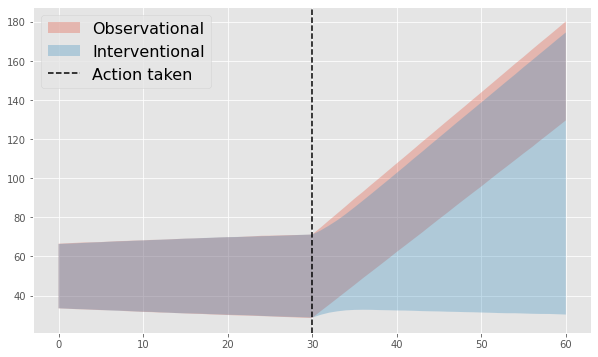

In [11]:
plt.figure(figsize=(10,6))
plt.style.use('ggplot')
plt.fill_between(range(T), q05_obs, q95_obs, alpha=0.3, label='Observational')
plt.fill_between(range(T), q05_int, q95_int, alpha=0.3, label='Interventional')
plt.axvline(t_act-1, color='k', linestyle='--', label='Action taken')
plt.legend(loc='upper left', fontsize=16)


74it [00:00, 76.67it/s]
36it [00:00, 91.30it/s]


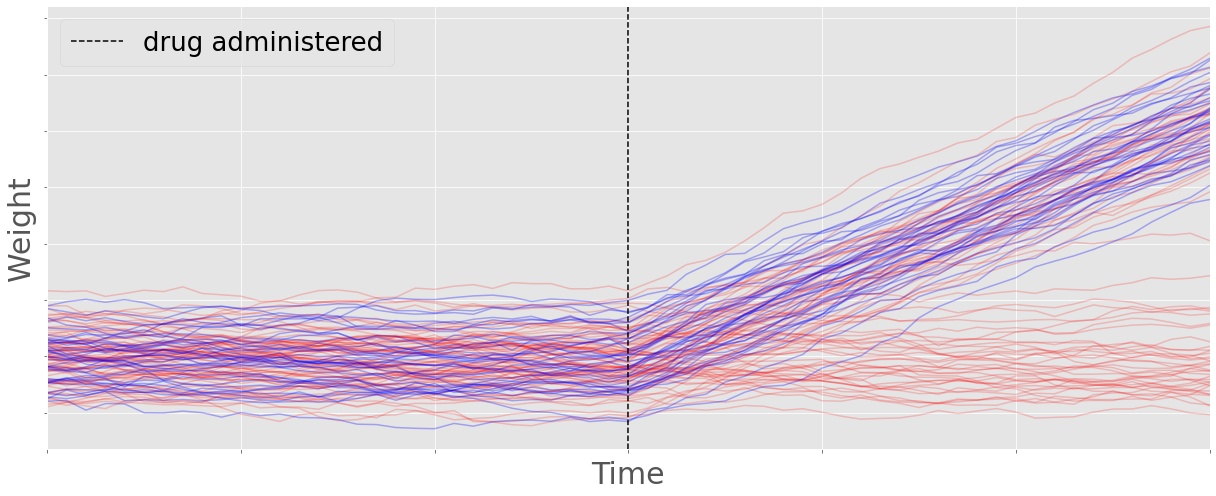

In [12]:
import seaborn as sns
fig, axs = plt.subplots(1, 1, figsize=(17,7))
plt.style.use('ggplot')
# sns.color_palette("mako", 10)[6],
max_count = 75

i=0        
for index, row in tqdm(interventional_data.iterrows()):
    i += 1
    plt.plot(range(T), row[[f'X_{t}' for t in range(T)]], color='red', alpha=0.2)
    if i == max_count:
        break


i=0
for index, row in tqdm(data_subset.iterrows()):
    i += 1
    plt.plot(range(T), row[[f'X_{t}' for t in range(T)]], color='blue', alpha=0.3)
    if i == max_count//2:
        break


plt.axvline(t_act-1, color='k', linestyle='--', label='drug administered')
plt.legend(loc='upper left', fontsize=26)
plt.xlim([0, 60])

axs.set_yticklabels([])
axs.set_xticklabels([])

axs.tick_params(axis='both', which='major', labelsize=24)
axs.tick_params(axis='both', which='minor', labelsize=24)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Weight', fontsize=30)
plt.tight_layout()

plt.savefig("/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/images/synthetic_example_newest2.pdf", format='pdf', bbox_inches='tight')
